In [98]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/Project4-power-grid/pca_koopman', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils', '../utils', '../utils', '../utils']


In [100]:
import yaml

config_path = '/home/shiqi/code/Project4-power-grid/pca_koopman/outputs/experiment_1/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [101]:
save_dir = config['save_dir']
train_data_dir = config['data_dir']
# test_data_dir = '/home/shiqi/code/model_combination_Argos/data_linear_1000_test'

train_loss = np.load(os.path.join(save_dir, 'train_losses.npy'))
test_loss = np.load(os.path.join(save_dir, 'test_losses.npy'))


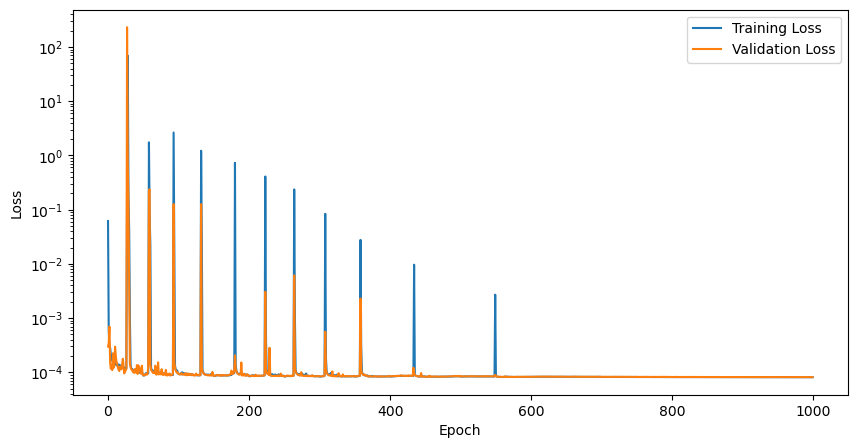

In [102]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

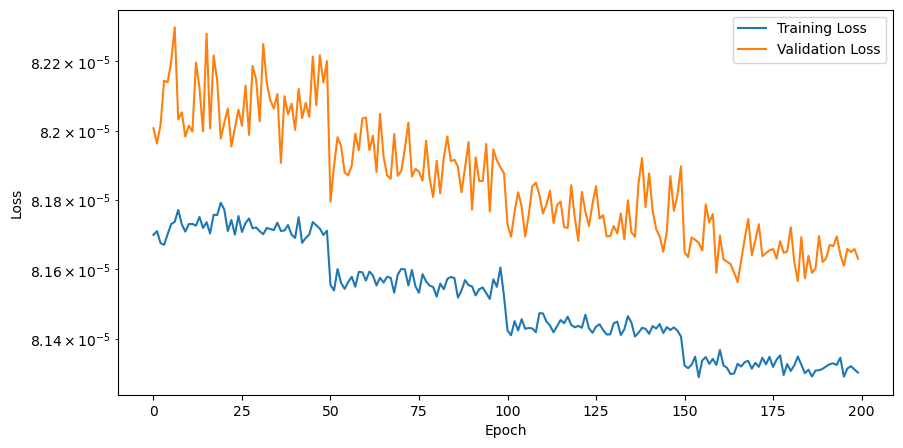

In [103]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss[800:], label='Training Loss')
plt.plot(test_loss[800:], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [104]:
# model
import pca_koopman_dir as km
import torch

# Device
device = 'cpu'
print('Device:', device)

x_dataset, u_dataset = load_dataset_from_files(config)
x_data = np.concatenate(x_dataset, axis=0)
u_data = np.concatenate(u_dataset, axis=0)
x_dim = np.shape(x_data)[1]
u_dim = np.shape(u_data)[1]
params = km.Params(x_dim=x_dim, u_dim=u_dim, config = config)
model = km.build_model_MatrixWithInputs(params, x_data, u_data)
model = model.to(device)

Device: cpu


In [105]:
# load dict
model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth'), map_location=device))

<All keys matched successfully>

In [106]:
window_size = np.shape(x_dataset[0])[0]
predict_num = 50
x_data_slices = cut_slides(x_data, window_size, predict_num)
u_data_slices = cut_slides(u_data, window_size, predict_num)

In [107]:
print(len(x_data_slices))
print(np.shape(x_data_slices[0]))

404160
(1, 50, 68)


In [108]:
import random
indices = list(range(len(x_data_slices)))
random.shuffle(indices)
sample_indices = indices[:500]
x_samples = [x_data_slices[i] for i in sample_indices]
u_samples = [u_data_slices[i] for i in sample_indices]
x_dataset = x_samples
u_dataset = u_samples
print(x_dataset[0].shape)


(1, 50, 68)


In [109]:
begin = 0
end = 50

x_dataset_pred = []
x_dataset_true = []
x_pca_dataset_pred = []
x_pca_dataset_true = []

i = 0

for x_data, u_data in zip(x_dataset, u_dataset):
    i+=1
    steps = end - begin   

    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
    x_data = x_data.squeeze(0)
    u_data = u_data.squeeze(0)
    x_pred = torch.zeros_like(x_data).to(device)
    x_pred[0, :] = x_data[0, :]
    # print(x_data[0, :].shape)
    x0_pca = model.encode(x_data[0, :].reshape(1, -1))
    # print(x0_pca.shape)
    for step in range(1, steps):
        u = u_data[step-1, :].reshape(1, -1)
        # print(u.shape)
        x1_pca = model.pca_forward(x0_pca, u)
        x_pred[step, :] = model.pca_decode(x1_pca)
        x0_pca = x1_pca
    x_dataset_pred.append(x_pred.detach().cpu().numpy())
    x_dataset_true.append(x_data.detach().cpu().numpy())
    x_pca_true = model.minmax_layer_1.transform(x_data.detach())
    x_pca_true = model.pca_transformer.transform(x_pca_true)
    x_pca_pred = model.minmax_layer_1.transform(x_pred.detach())
    x_pca_pred = model.pca_transformer.transform(x_pca_pred)
    x_pca_dataset_true.append(x_pca_true)
    x_pca_dataset_pred.append(x_pca_pred)
    print("The {}th data is predicted".format(i))

The 1th data is predicted
The 2th data is predicted
The 3th data is predicted
The 4th data is predicted
The 5th data is predicted
The 6th data is predicted
The 7th data is predicted
The 8th data is predicted
The 9th data is predicted
The 10th data is predicted
The 11th data is predicted
The 12th data is predicted
The 13th data is predicted
The 14th data is predicted
The 15th data is predicted
The 16th data is predicted
The 17th data is predicted
The 18th data is predicted
The 19th data is predicted
The 20th data is predicted
The 21th data is predicted
The 22th data is predicted
The 23th data is predicted
The 24th data is predicted
The 25th data is predicted
The 26th data is predicted
The 27th data is predicted
The 28th data is predicted
The 29th data is predicted
The 30th data is predicted
The 31th data is predicted
The 32th data is predicted
The 33th data is predicted
The 34th data is predicted
The 35th data is predicted
The 36th data is predicted
The 37th data is predicted
The 38th d

In [110]:
print(np.shape(x_pca_dataset_pred[0]))

torch.Size([50, 10])


In [111]:
errors = [x_dataset_true[i] - x_dataset_pred[i] for i in range(len(x_dataset_true))]
errors_pca = [x_pca_dataset_true[i] - x_pca_dataset_pred[i] for i in range(len(x_pca_dataset_true))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]
cumulative_error_norms_pca = [np.array([np.linalg.norm(errors_pca[i][:j+1,:]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))]

data_norms = [np.linalg.norm(x_dataset_true[i]) for i in range(len(x_dataset_true))]

data_norms_pca = [np.linalg.norm(x_pca_dataset_true[i]) for i in range(len(x_pca_dataset_true))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

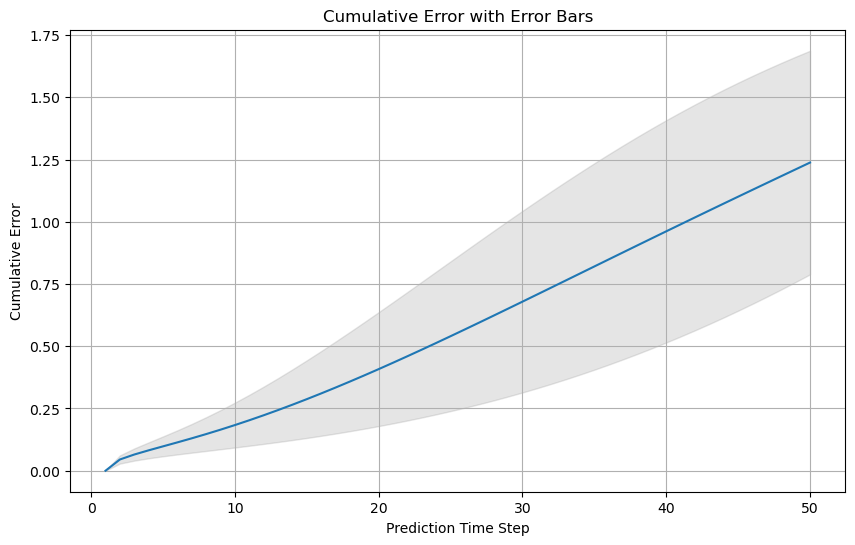

In [112]:
import matplotlib.pyplot as plt
xx = range(1,51)

# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
upper_bound = mean_relative_errors + std_relative_errors
lower_bound = mean_relative_errors - std_relative_errors

plt.plot(xx, mean_relative_errors[:len(xx)], '-', label='Mean Cumulative Error')
plt.fill_between(xx, lower_bound[:len(xx)], upper_bound[:len(xx)], color='gray', alpha=0.2)
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [113]:
errors_pca = [x_pca_dataset_pred[i] - x_pca_dataset_true[i] for i in range(len(x_pca_dataset_true))]

cumulative_error_norms_pca = []
for k in range(10):
    cur_dim_norm = np.array([np.array([np.linalg.norm(errors_pca[i][:j+1,k]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))])
    cumulative_error_norms_pca.append(cur_dim_norm)

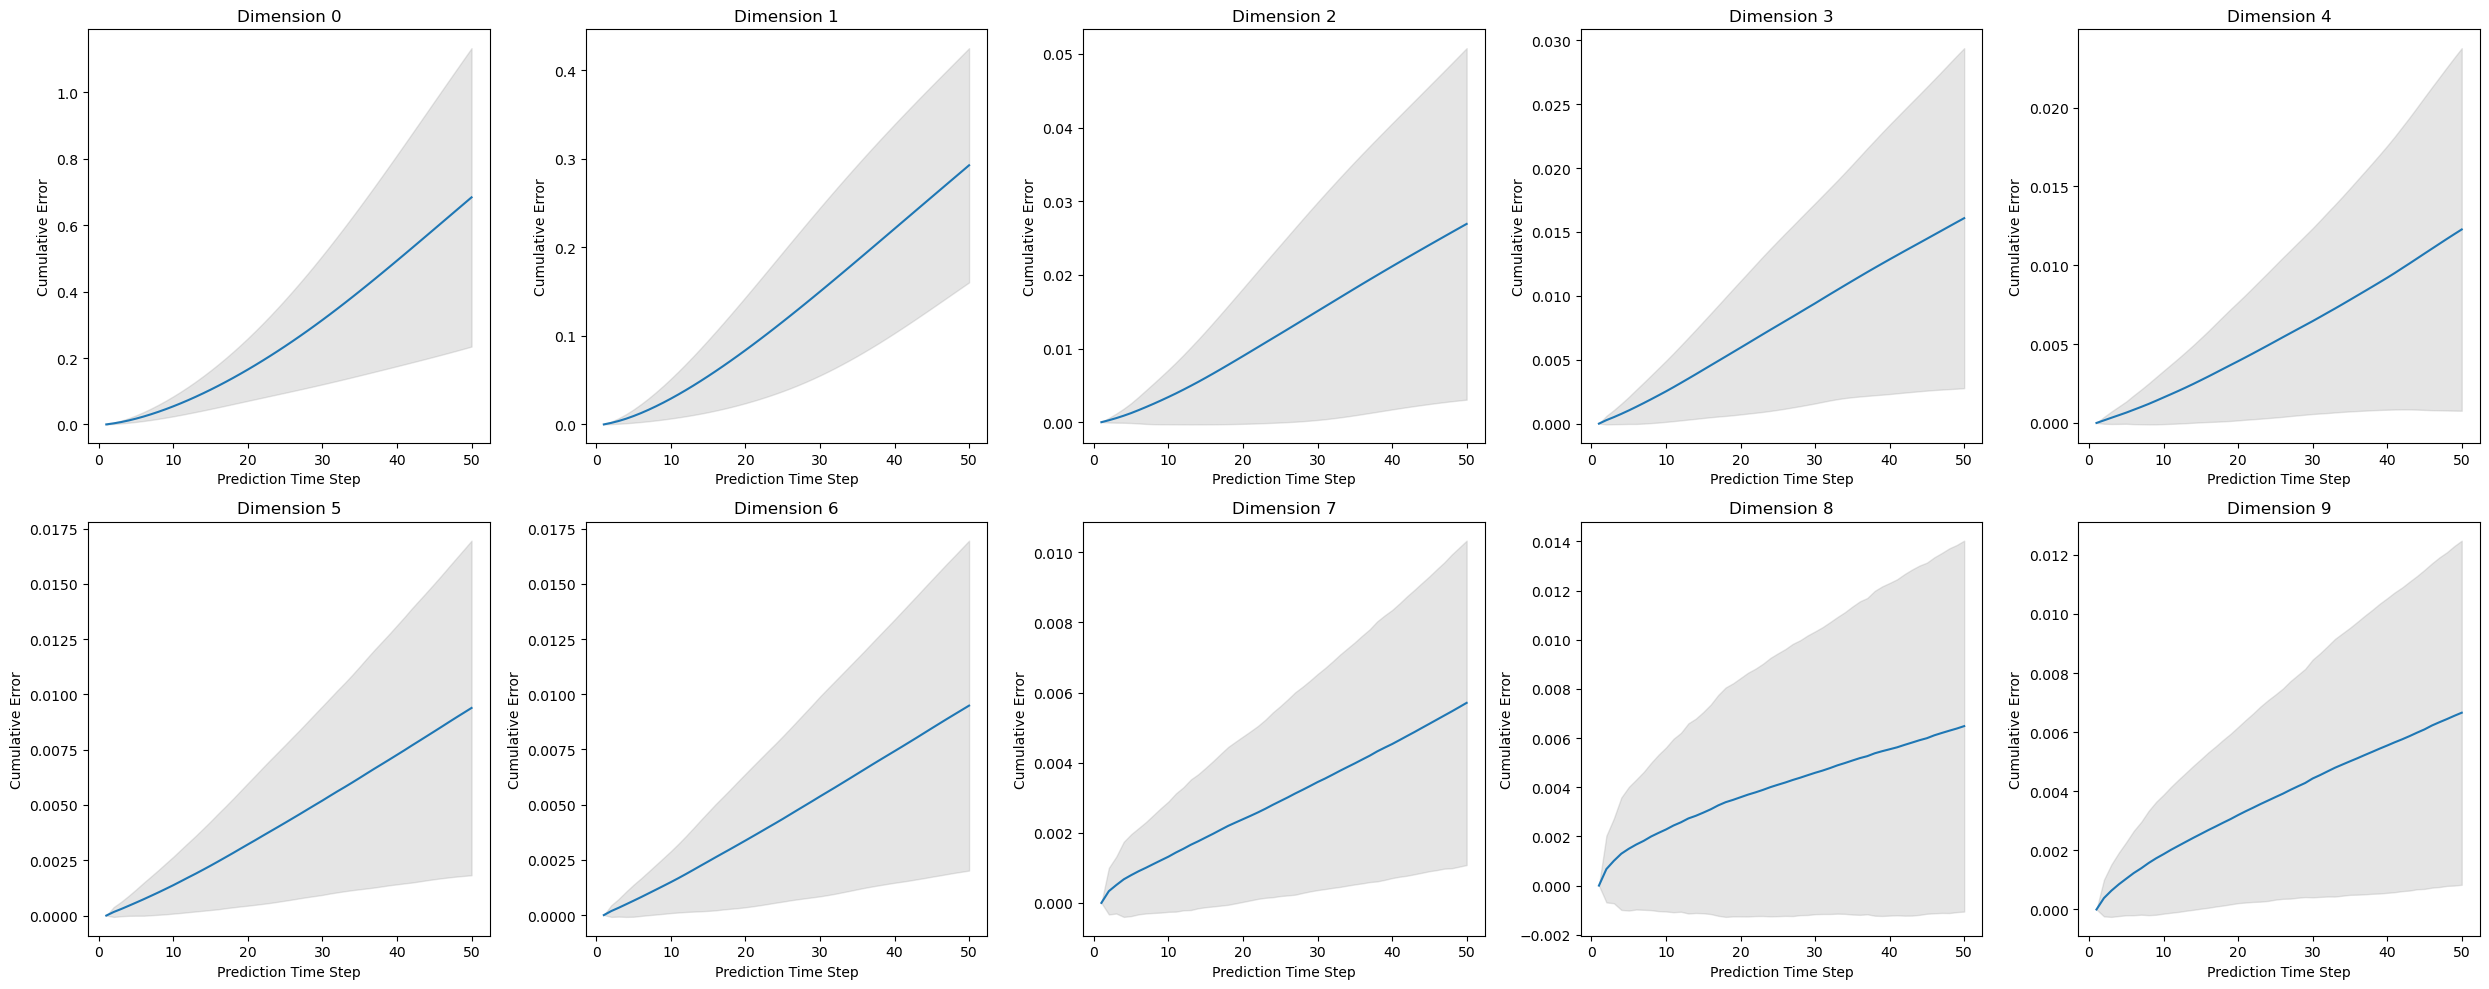

In [114]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming window_size, cumulative_error_norms_pca, x_data_pca_traj, and other variables are defined

fig, axs = plt.subplots(2, 5, figsize=(25, 10))  # Create a subplot layout with 2 rows and 5 columns

for dim in range(10):  # Adjust this range if you have more or fewer dimensions
    # Calculate mean and standard deviation of relative errors
    mean_relative_errors_pca = np.mean([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_pca_dataset_true[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)
    std_relative_errors_pca = np.std([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_pca_dataset_true[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)

    # Calculate error bounds
    upper_bound = mean_relative_errors_pca + std_relative_errors_pca
    lower_bound = mean_relative_errors_pca - std_relative_errors_pca

    x_axis = range(1, 51)
    # Determine the row and column for each subplot based on the dimension index
    row = dim // 5  # Determines the row by integer division
    col = dim % 5   # Determines the column by taking the remainder

    # Plot the mean cumulative error curve
    axs[row, col].plot(x_axis, mean_relative_errors_pca[:len(x_axis)], '-', label='Mean Cumulative Error')
    
    # Fill the area between bounds to indicate error range
    axs[row, col].fill_between(x_axis, lower_bound[:len(x_axis)], upper_bound[:len(x_axis)], color='gray', alpha=0.2)

    axs[row, col].set_xlabel('Prediction Time Step')
    axs[row, col].set_ylabel('Cumulative Error')
    axs[row, col].set_title(f'Dimension {dim}')

plt.tight_layout()
plt.show()


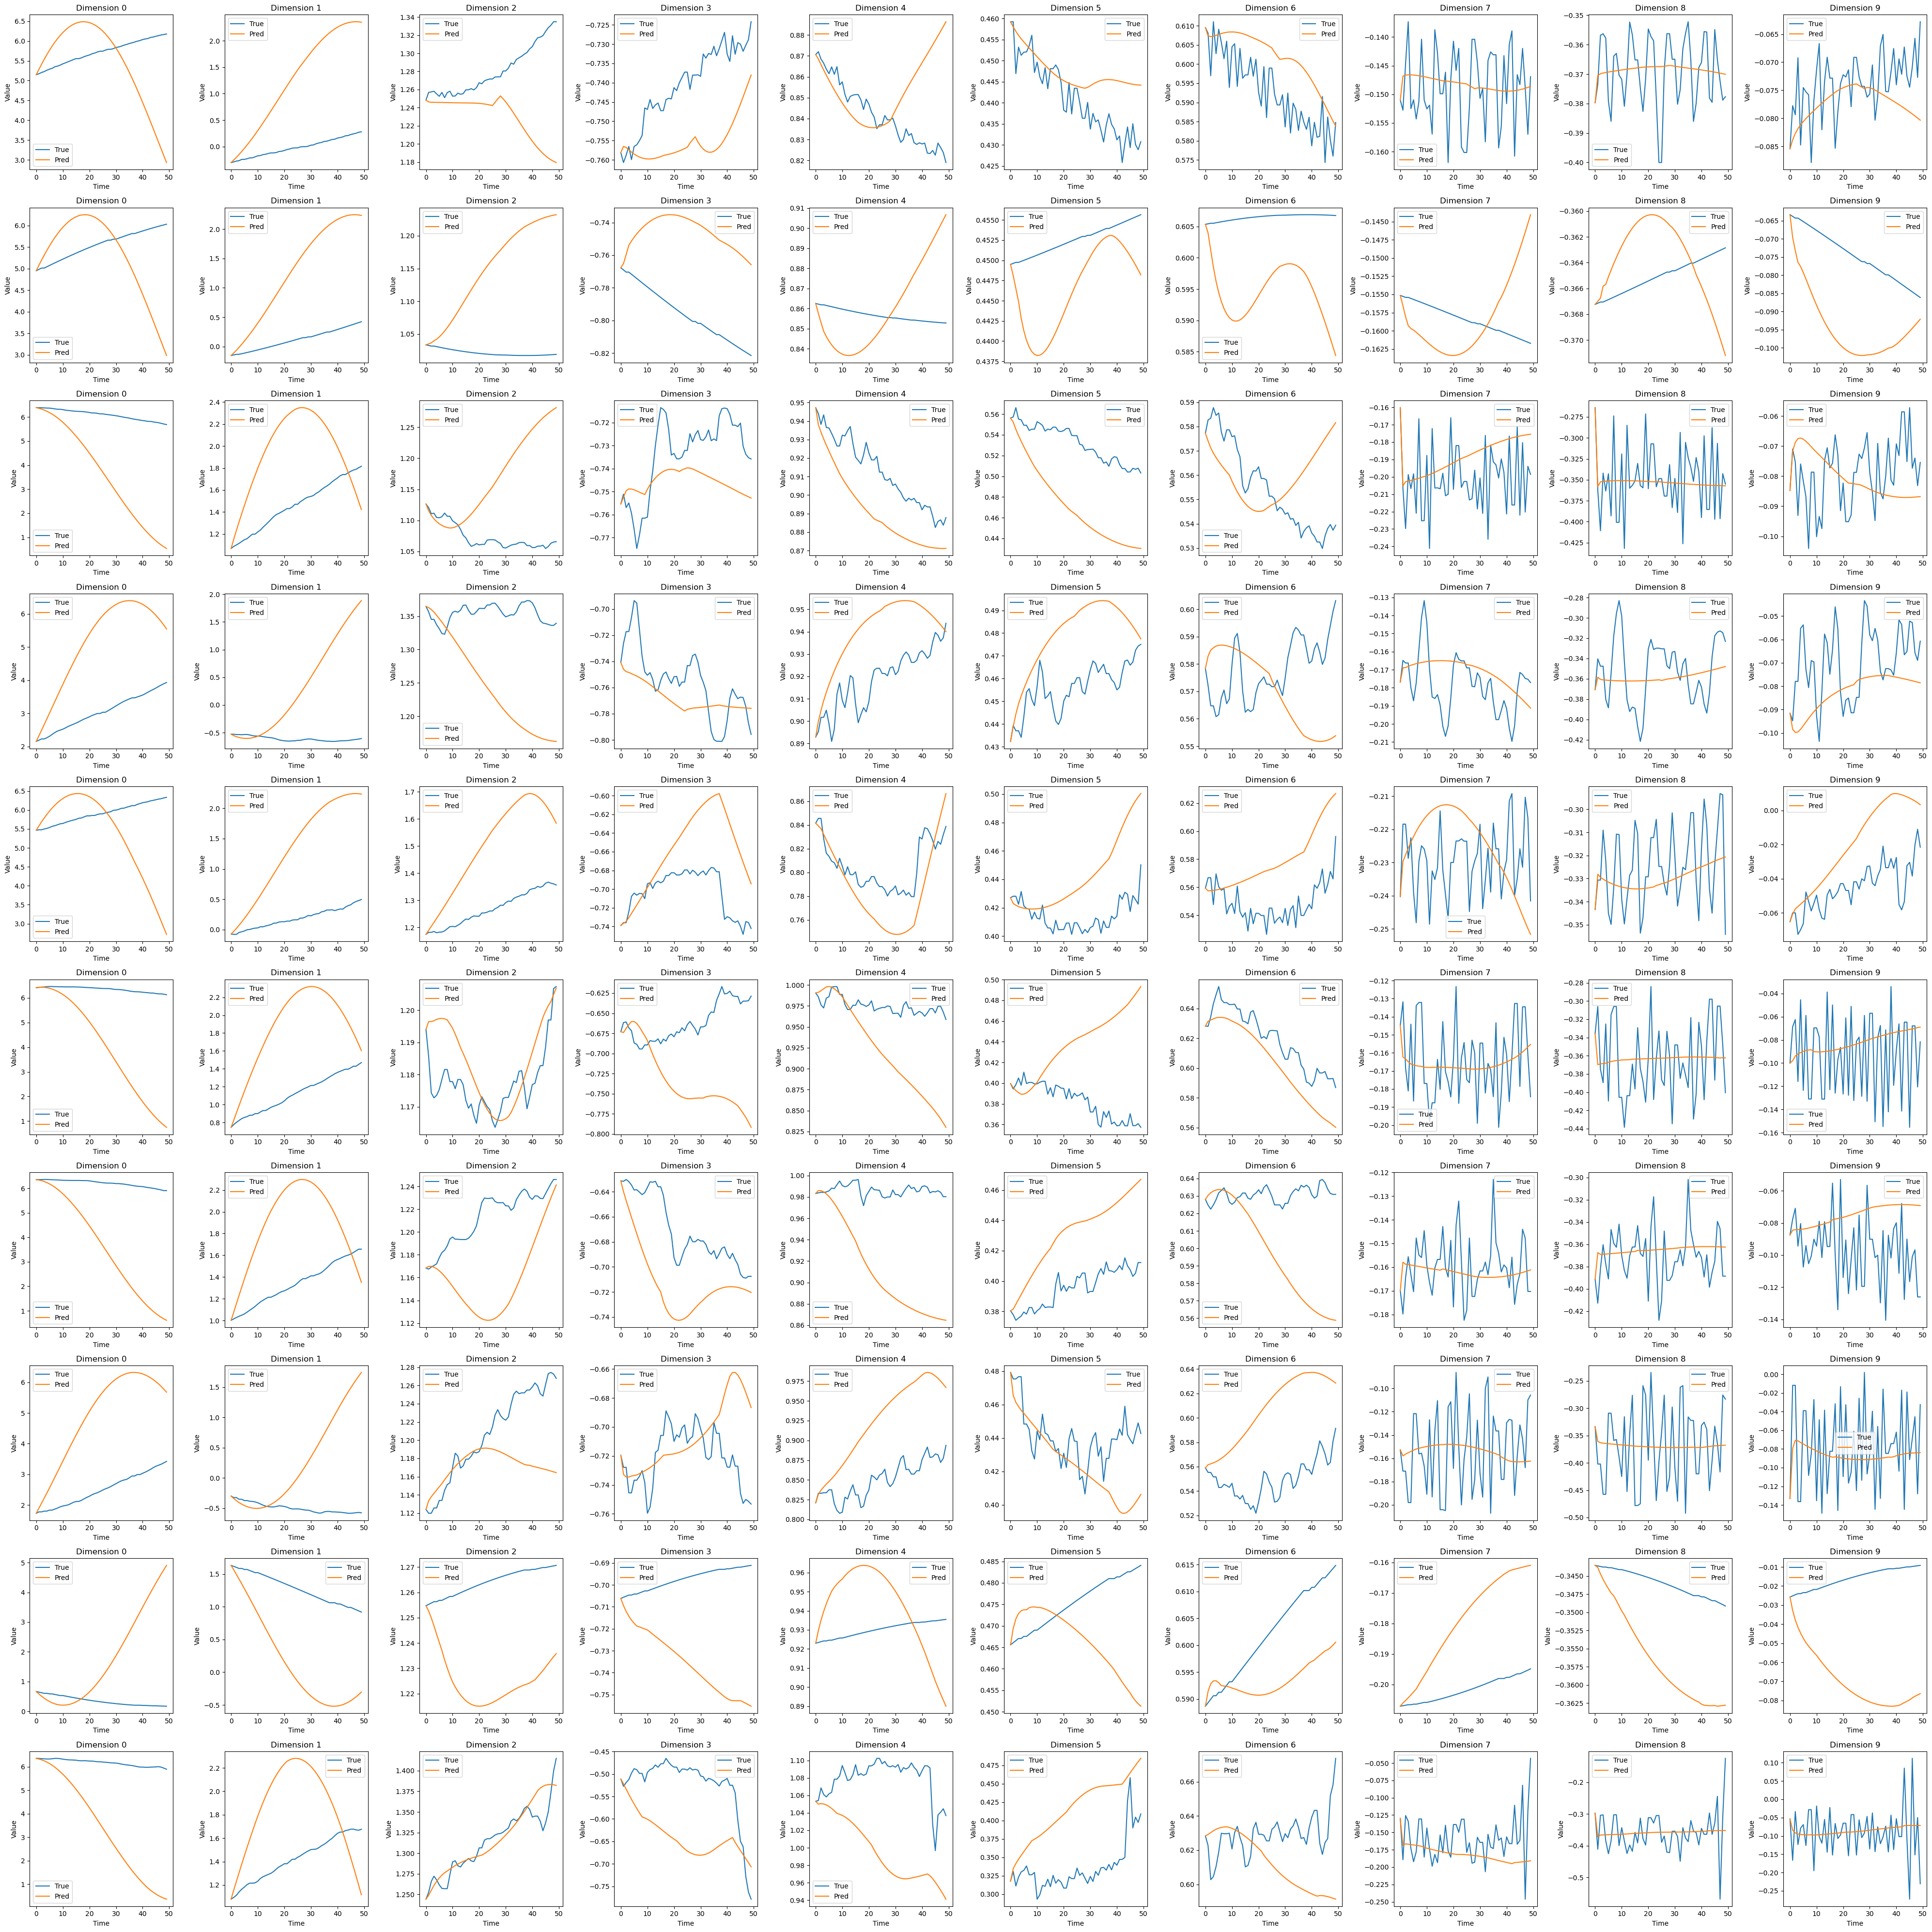

In [115]:
# Plot
import matplotlib.pyplot as plt
import numpy as np
import random

# Select random indexs
random.seed(0)
ks = random.sample(range(len(x_dataset_true)), 10)

# Plot the true and predicted trajectories

fig, axs = plt.subplots(len(ks), 10, figsize=(40, len(ks) * 4))

# y_min, y_max = float('inf'), float('-inf')

for k in ks:
    x_true = x_pca_dataset_true[k]
    x_pred = x_pca_dataset_pred[k]
    # y_min = min(y_min, np.min(x_true.detach().cpu().numpy()))
    # y_max = max(y_max, np.max(x_true.detach().cpu().numpy()))

for idx, k in enumerate(ks):
    x_true = x_pca_dataset_true[k]
    x_pred = x_pca_dataset_pred[k]

    for dim in range(10):
        ax = axs[idx, dim]
        ax.plot(x_true[:, dim], label='True')  # 绘制真实值
        ax.plot(x_pred[:, dim], label='Pred')  # 绘制预测值
        ax.set_title(f'Dimension {dim}')  # 设置标题
        ax.set_xlabel('Time')  # 设置x轴标签
        ax.set_ylabel('Value')  # 设置y轴标签
        # ax.set_ylim([y_min, y_max])
        ax.legend()  # 显示图例

plt.tight_layout()  # 调整布局
plt.show()  # 显示图形
